In [1]:
import numpy as np
import tensorflow as tf
from absl import app, flags
from easydict import EasyDict
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from sklearn import datasets
from sklearn.model_selection import train_test_split
import time
from IPython.display import clear_output
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pickle
import pandas as pd

### Initial Experiment (no modification) ###

In [2]:
filename = 'data/dataset_IM_1B.pkl'

with open(filename, 'rb') as f:
    data_tuples = pickle.load(f)
f.close()

In [3]:
print('Number of Data Points:', len(data_tuples))
class_labels = []
for i in range(len(data_tuples)):
    class_labels.append(data_tuples[i][1])

print('Class Labels:', len(set(class_labels)))
print('Feature Count:', len(data_tuples[0][0]) ** 2)

Number of Data Points: 6000
Class Labels: 6
Feature Count: 784


In [4]:
# intrinsic dimension performed elsewhere

data = pd.DataFrame([i[0].flatten() for i in data_tuples])
labels = np.array([i[1] for i in data_tuples])

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

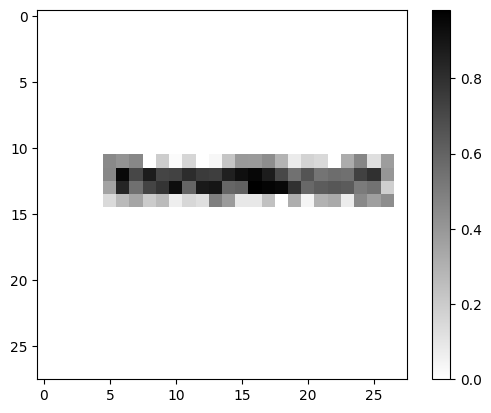

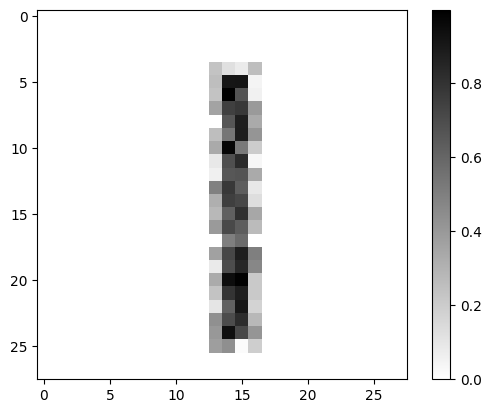

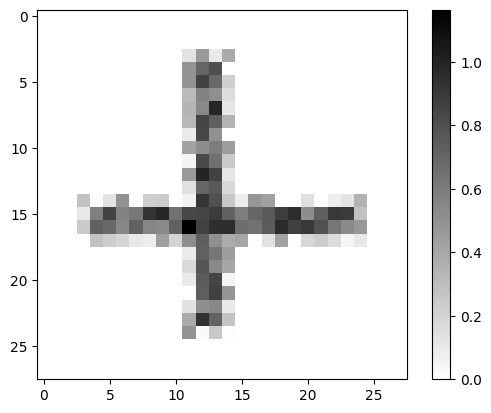

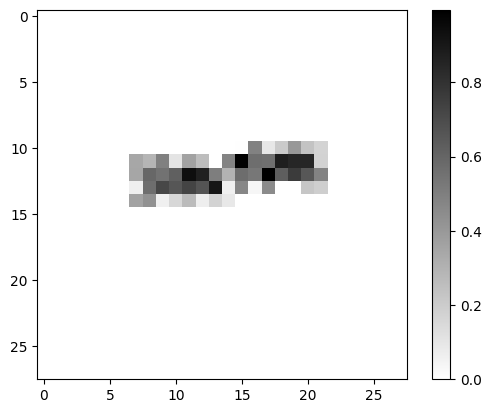

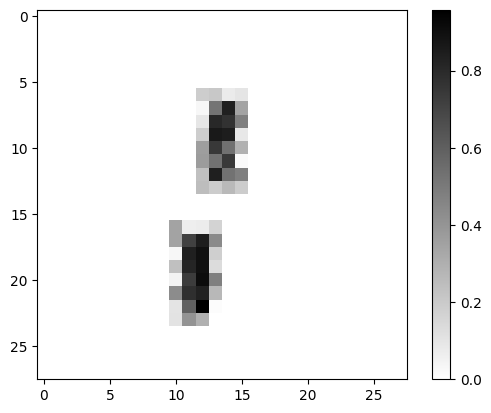

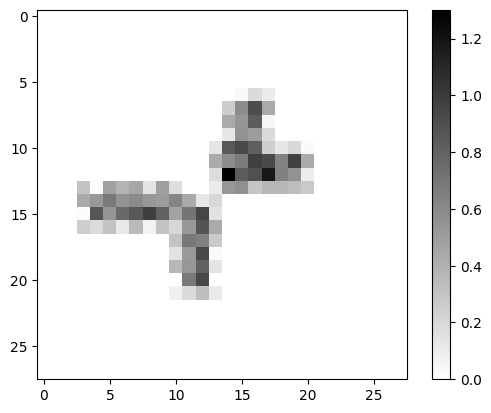

In [6]:
for d in range(len(set(class_labels))):
    class_instance = [i[0].flatten() for i in data_tuples if i[1] == d][0]
    instance = class_instance.reshape(28,28)
    plt.figure()
    plt.imshow(instance, cmap=plt.cm.gray_r)
    plt.colorbar()
    plt.grid(False)
    plt.colormaps
    plt.show()

In [7]:
ID = 20

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28*28)),
    tf.keras.layers.Dense(ID, activation='relu'),
    tf.keras.layers.Dense(6)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

start_time = time.time()

model.fit(x_train, y_train, epochs=10)

clear_output(wait=True)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1.9690251350402832 seconds ---


In [10]:
test_loss, test_acc = model.evaluate(x_test,  y_test)
f1 = f1_score(y_test, [np.argmax(a) for a in model.predict(x_test)], average='weighted')

print('\nTest accuracy:', test_acc)
print('\nTest F1 (weighted):', f1)

38/38 [==============================] - 0s 685us/step

Test accuracy: 1.0

Test F1 (weighted): 1.0


### PGD Experiment (modification) ###
Establish values for attack testing and training the model:

In [11]:
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

Defining the model architecture and metrics:

In [12]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

In [15]:
test_acc_clean = tf.metrics.SparseCategoricalAccuracy()
test_acc_fgsm = tf.metrics.SparseCategoricalAccuracy()
test_acc_pgd = tf.metrics.SparseCategoricalAccuracy()

In [46]:
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state([[2], [1]], [[0.1, 0.6, 0.3], [0.05, 0.95, 0]])
m.result().numpy()

0.5

In [40]:
test_acc_pgd.count

<tf.Variable 'count:0' shape=() dtype=float32, numpy=4800.0>

In [83]:
ID = 20

flags_nb_epochs = 50       # number of epochs
flags_eps = 0.01           # Total epsilon for FGM and PGD attacks
flags_adv_train = False    # Use adversarial training (on PGD adversarial examples).

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28*28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(ID, activation='relu'),
    tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

start_time = time.time()

model.fit(x_train, y_train, epochs=10)

clear_output(wait=True)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1.8094065189361572 seconds ---


In [84]:
# Evaluate on clean and adversarial data
x = tf.constant(x_test.astype('float32'))
y = y_test
# y_pred = model(x)
# test_acc_clean(y, y_pred)

x_pgd = projected_gradient_descent(model, x, flags_eps, 0.001, 100, np.inf)
y_pred_pgd = model(x_pgd)
test_acc_pgd.update_state(y, y_pred_pgd)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=24000.0>

In [85]:
print(
    "test acc on clean examples (%): {:.3f}".format(test_acc_clean.result() * 100)
)
print(
    "test acc on PGD adversarial examples (%): {:.3f}".format(
        test_acc_pgd.result() * 100
    )
)

test acc on clean examples (%): 100.000
test acc on PGD adversarial examples (%): 57.312


### Examples of Accuracy and F1 from PGD ###
PGD epsilon: 0.01; Epsilon Iteration - 0.001; 100 attack iterations, no normalization
- ID=20:   (0.985 accuracy, 0.985 F1)
- ID=500:  (0.996 accuracy, 0.996 F1)

Regular Accuracy: 1.0
PGD Accuracy: 0.9841666666666666

Regular Macro F1: 1.0
PGD Macro F1: 0.984165692565505


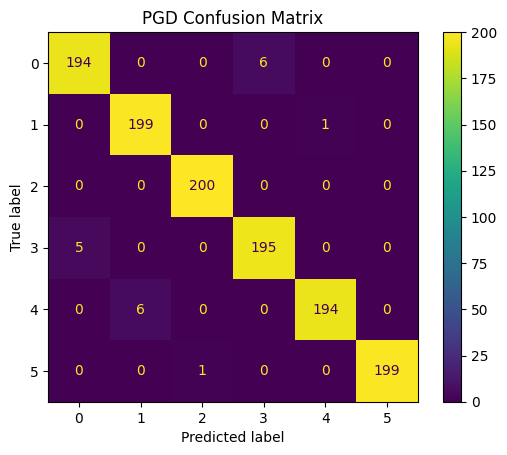

In [60]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("Regular Accuracy:", accuracy_score(y, [np.argmax(a) for a in y_pred]))
print("PGD Accuracy:", accuracy_score(y, [np.argmax(a) for a in y_pred_pgd]))
print("\nRegular Macro F1:", f1_score(y, [np.argmax(a) for a in y_pred], average='macro'))
print("PGD Macro F1:", f1_score(y, [np.argmax(a) for a in y_pred_pgd], average='macro'))

cm = confusion_matrix(y_test, [np.argmax(a) for a in y_pred_pgd], labels=[0,1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5])
disp.plot()
plt.title("PGD Confusion Matrix")
plt.show()

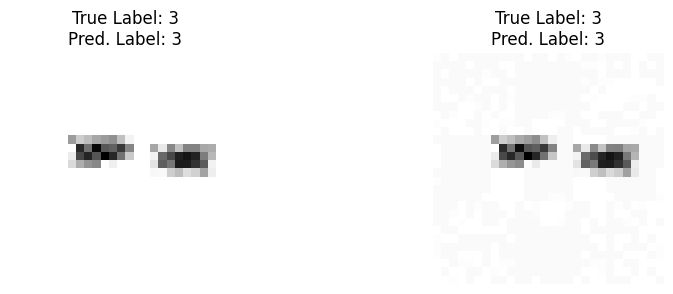

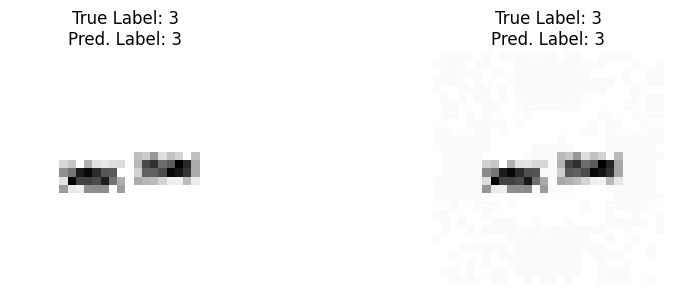

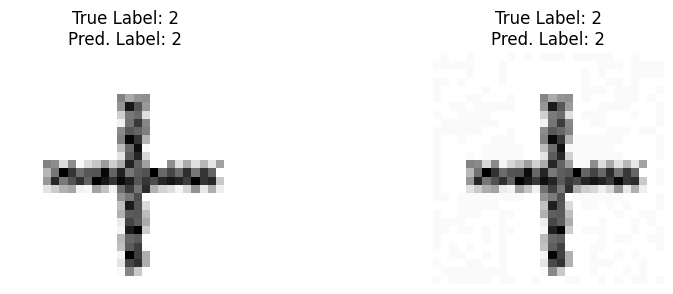

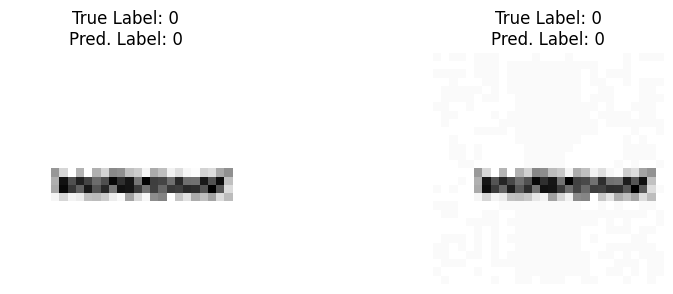

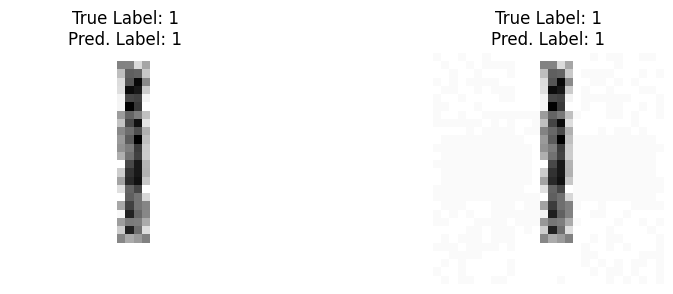

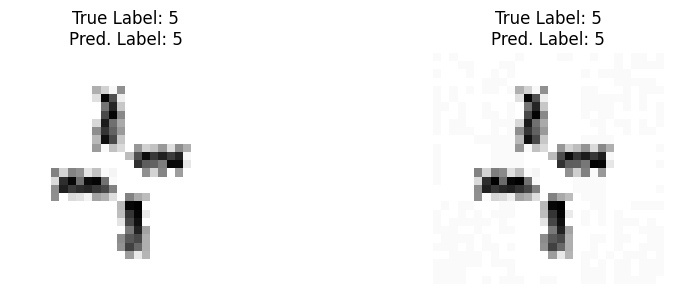

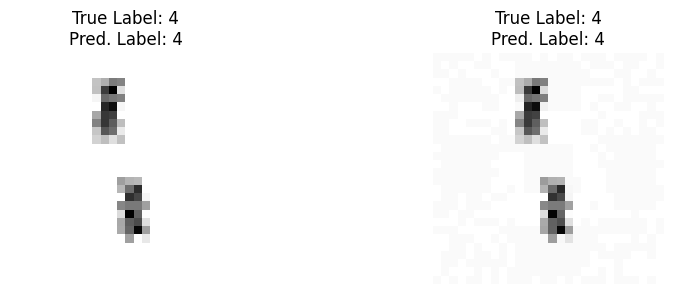

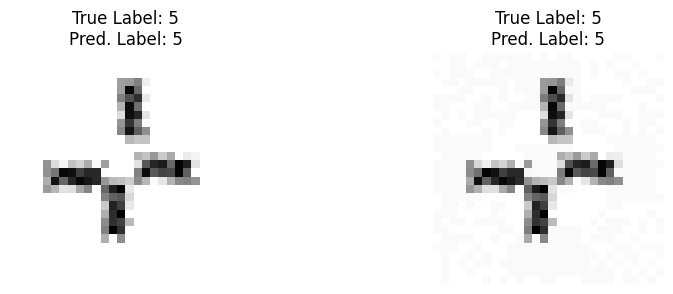

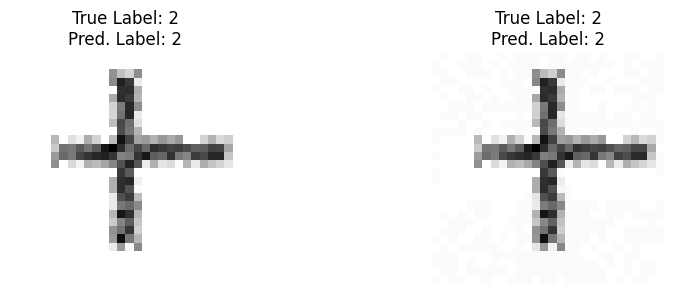

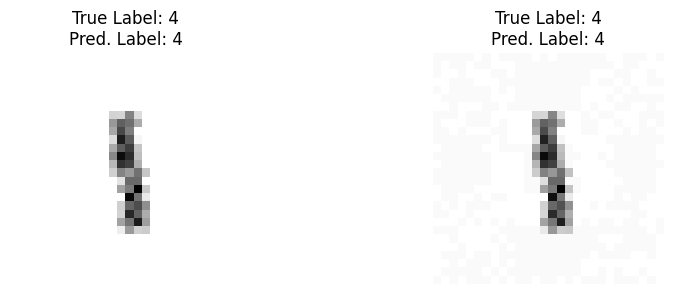

In [61]:
for index in range(0,10):
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    for ax, image, label, pred in zip(axes, 
                                [x, x_pgd], 
                                np.full((10), y[index]),
                                [np.argmax(y_pred[index]), np.argmax(y_pred_pgd[index])]
                               ):
        image = image[index].numpy()
        ax.set_axis_off()
        ax.imshow(image.reshape(28,28), cmap=plt.cm.gray_r, interpolation="nearest")
        ax.set_title("True Label: {}\nPred. Label: {}".format(label, pred))

Total Mismatches: 19


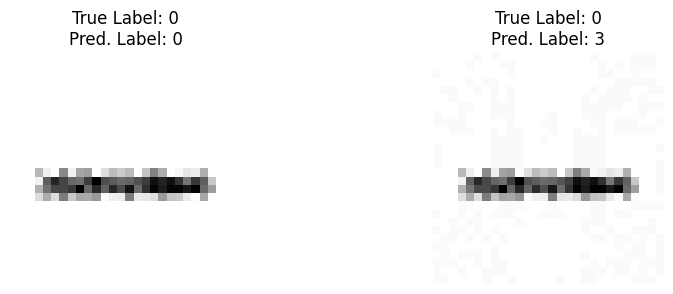

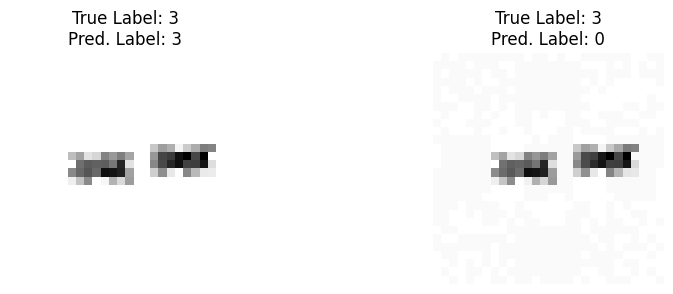

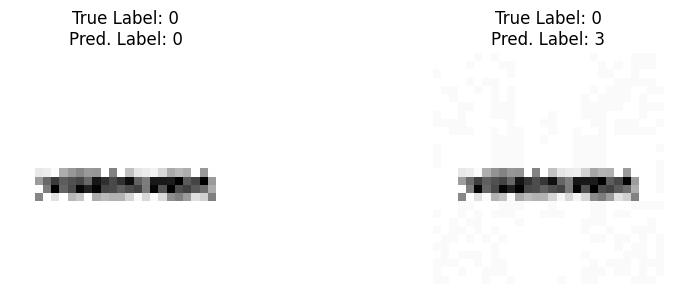

In [62]:
wrong_list = []

for i in range(len(y_test)):
    if (y_test[i] != np.argmax(y_pred_pgd[i])) and (y_test[i] == np.argmax(y_pred[i])):
        wrong_list.append(i)
        
print("Total Mismatches:", len(wrong_list))
        
for index in wrong_list[:3]:
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    for ax, image, label, pred in zip(axes, 
                                [x, x_pgd], 
                                np.full((10), y[index]),
                                [np.argmax(y_pred[index]), np.argmax(y_pred_pgd[index])]
                               ):
        image = image[index].numpy()
        ax.set_axis_off()
        ax.imshow(image.reshape(28,28), cmap=plt.cm.gray_r, interpolation="nearest")
        ax.set_title("True Label: {}\nPred. Label: {}".format(label, pred))